# 🧩 Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
!pip install --upgrade protobuf==3.20.*
!pip install --upgrade tensorflow==2.12.0
!pip install --upgrade keras==2.12.
pip install tensorflow opencv-python numpy



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical



# 🗂️ Dataset Path


In [4]:

data_dir = "/kaggle/input/fer2013/train"  # change this if needed
test_dir = "/kaggle/input/fer2013/test"


# 🧼 Data Preprocessing

In [5]:
img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# 🔍 Check Class Labels
print(train_data.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# 🧠 Build CNN Model

In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📚 Model Summary


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

# 🚀 Train the Model

In [9]:
epochs = 30
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs
)

Epoch 1/30
449/449 [==============================] - 190s 419ms/step - loss: 1.7443 - accuracy: 0.2928 - val_loss: 1.5898 - val_accuracy: 0.3952
Epoch 2/30
449/449 [==============================] - 59s 131ms/step - loss: 1.5208 - accuracy: 0.4117 - val_loss: 1.4073 - val_accuracy: 0.4529
Epoch 3/30
449/449 [==============================] - 58s 129ms/step - loss: 1.4086 - accuracy: 0.4596 - val_loss: 1.3334 - val_accuracy: 0.4918
Epoch 4/30
449/449 [==============================] - 58s 128ms/step - loss: 1.3372 - accuracy: 0.4911 - val_loss: 1.2664 - val_accuracy: 0.5146
Epoch 5/30
449/449 [==============================] - 58s 129ms/step - loss: 1.2788 - accuracy: 0.5153 - val_loss: 1.2279 - val_accuracy: 0.5334
Epoch 6/30
449/449 [==============================] - 59s 130ms/step - loss: 1.2330 - accuracy: 0.5314 - val_loss: 1.2104 - val_accuracy: 0.5393
Epoch 7/30
449/449 [==============================] - 58s 129ms/step - loss: 1.1950 - accuracy: 0.5501 - val_loss: 1.1949 - val_a

# 💾 Save the Model

In [10]:
model.save("emotion_model.h5")
print("Model saved successfully!")

Model saved successfully!


# 📈 Plot Accuracy and Loss

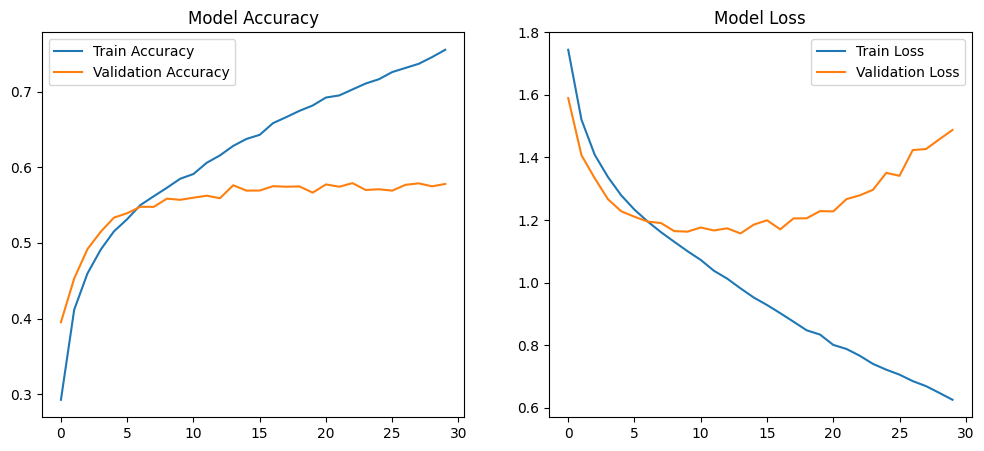

In [11]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


# 🧍‍♀️ Real-Time Emotion Detection (Optional)

In [19]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load the face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
emotion_dict = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# Load your model (example)
# model = load_model('emotion_model.h5')

# Upload your video file to Colab/Kaggle and put its path here
cap = cv2.VideoCapture('/content/test_video.mp4')

if not cap.isOpened():
    print("❌ Cannot open video file")
else:
    print("✅ Video file opened successfully")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Video finished or cannot read frame.")
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi = roi_gray.reshape(1, 48, 48, 1) / 255.0
        # prediction = model.predict(roi)
        # emotion_label = emotion_dict[np.argmax(prediction)]
        emotion_label = "Happy"  # temporary label for testing

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2_imshow(frame)
    break  # show only one frame for testing

cap.release()
print("✅ Done!")


❌ Cannot open video file
Video finished or cannot read frame.
✅ Done!
